In [1]:
from os import listdir
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from nltk.metrics.distance import edit_distance

In [2]:
MISSING = " "

# Load Data

## Charts

In [3]:
files = listdir("../chart")

dfs_chart = {}
for f in files:
    year = f.split("_")[0]
    month = f.split("_")[1].split(".")[0]

    if dfs_chart.get(year) is None:
        dfs_chart[year] = {}
        
    dfs_chart[year][month] = pd.read_csv("../chart/" + f)

In [4]:
dfs_chart["2006"]["Janvier"].head(3)

,Rank,Artist,Music
0,1,juanes,la camisa negra
1,2,madonna,hung up
2,3,johnny hallyday,mon plus beau noël


In [5]:
chart = []
for k1 in dfs_chart.keys():
    for k2 in dfs_chart[k1].keys():
        chart.append(dfs_chart[k1][k2])
chart = pd.concat(chart)
chart.drop(columns=["Rank"], inplace=True)
chart.drop_duplicates(inplace=True)

## Artists

In [6]:
artist = pd.read_csv("../artist.csv", index_col=0)
artist.fillna(MISSING, inplace=True)

In [7]:
artist.head(3)

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary
Artist,,,,,,,
franko,Franko (rappeur),"26 décembre 1987 (34 ans)douala, cameroun",,,,,"franko, de son vrai nom kinguè franck junior, ..."
axwell & ingrosso,Axwell Λ Ingrosso,,,,,,"axwell λ ingrosso, prononcé axwell and ingross..."
silvercab,,,,,,,


# Analysis

In [8]:
artist.value_counts("Artist_wiki").sort_values() #Aucune page en wiki en double, ce qui est un bon signe !

Artist_wiki
LCD Soundsystem      1
1995 (groupe)        1
2 Chainz             1
24kGoldn             1
2NE1                 1
                  ... 
Étienne Daho         1
Yuksek               1
Zkr                  1
MANUEL              11
                   528
Length: 1707, dtype: int64

In [9]:
np.round(artist[artist["Artist_wiki"] == MISSING].shape[0] / artist.shape[0], 2) # 24% des artistes n'ont pas de page en wiki

0.24

In [10]:
artist = artist[artist["Artist_wiki"] != MISSING] #On ne garde que les artistes qui ont une page en wiki

In [11]:
#On recalcul les distances entre les noms d'artistes et les pages wikipédia pour vérifier
def calc_dist(artist, wiki):
    words = ["(chanteur)", "(chanteuse)", "(groupe)", "(rappeur)", "(rappeuse)", "(musicien)", "(chanteur français)", "(france)", "(producteur)", "(artiste)", "(groupe de musique)"]

    if any(w in wiki.lower() for w in words):
        dist = edit_distance(artist.lower().strip(), wiki.lower().split(" (")[0].strip())
        if dist/len(artist) < 0.4:
            return dist
    
    return edit_distance(artist.lower().strip(), wiki.lower().strip())

artist["distance"] = artist.apply(lambda x: calc_dist(x.name, x["Artist_wiki"]), axis=1)
artist["distance_norm"] = artist.apply(lambda x : x["distance"]/len(x.name), axis=1)

In [12]:
artist.sort_values("distance_norm", ascending=False).head() #Nos distances sont bonnes

,Artist_wiki,Naissance,Pays d'origine,Origine,Nationalité,Pays,Summary,distance,distance_norm
Artist,,,,,,,,,
glk,MANUEL,,,française,,,"Originaire de Bobigny, en Seine-Saint-Denis",6,2.000000
al. hy,MANUEL,15 novembre 1993,,française,,,"15 novembre 1993 (Âge: 29 ans), Saint-Amand-le...",6,1.000000
1pliké140,MANUEL,1963,,française,,,1PLIKÉ140 est un jeune rappeur français origin...,9,1.000000
bolémvn,MANUEL,29 novembre 1996,,française,,,Bryan Mounkala (né le 29 novembre 1996) mieux ...,7,1.000000
sound of legend,MANUEL,,,française,,,,13,0.866667


In [13]:
#Ajout de la colonne "Missing" pour voir ceux sur qui on n'a pas de données
artist["Missing"] = (
    (artist["Naissance"] == MISSING) &
    (artist["Pays d'origine"] == MISSING) &
    (artist["Origine"] == MISSING) &
    (artist["Nationalité"] == MISSING) &
    (artist["Nationalité"] == MISSING) &
    (artist["Summary"] == MISSING)
)

In [14]:
chart = chart.merge(artist, on="Artist", how="left")

In [15]:
#On regarde les artistes qui n'ont pas de page en wiki mais qui ont beaucoups de musique dans le top 100
chart[chart["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sort_values(ascending=False)

Artist
astrofonik            6
frédérique zoltane    5
narkotek              4
lylloo                3
string color          3
                     ..
gums                  1
guirri mafia          1
groove cats           1
graya                 1
öwnboss               1
Name: Music, Length: 528, dtype: int64

In [16]:
np.round(chart[chart["Artist_wiki"].isna()].groupby("Artist")["Music"].count().sum()/chart.shape[0], 3) # On perd 9% des musiques

0.096

In [17]:
#Artistes ayant le plus de musique dans le top 100
chart[chart.isna().sum(axis=1) >= 5].value_counts("Artist")

Artist
astrofonik            6
frédérique zoltane    5
narkotek              4
lylloo                3
string color          3
                     ..
gums                  1
guirri mafia          1
groove cats           1
graya                 1
öwnboss               1
Length: 528, dtype: int64

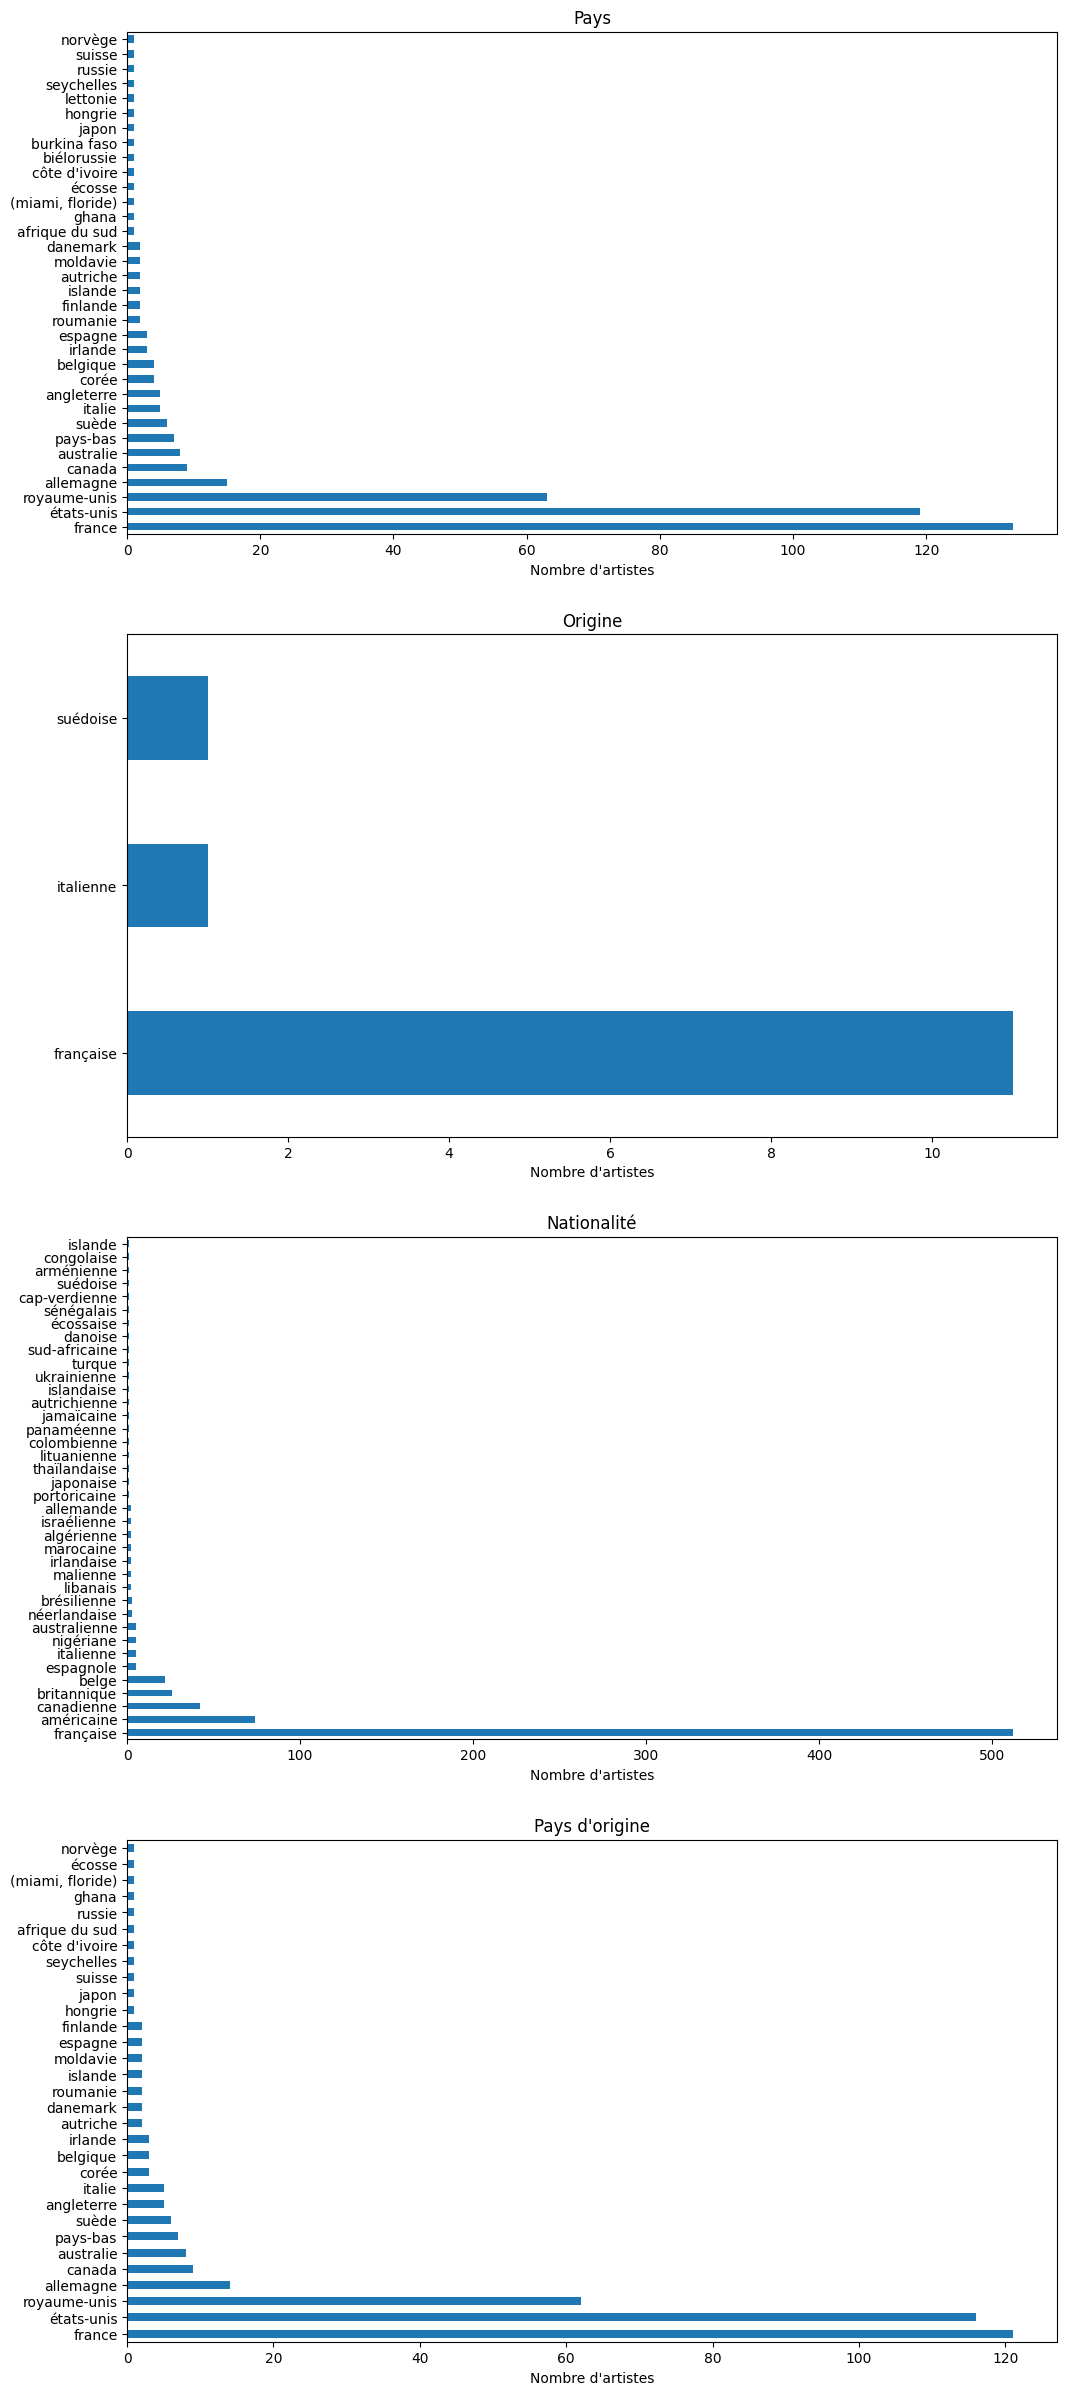

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(12, 30))
for axi, col in zip(ax.flatten(), ["Pays", "Origine", "Nationalité", "Pays d'origine"]):
    artist[col].value_counts()[1:].plot.barh(ax=axi, title=col)
    axi.set(xlabel="Nombre d'artistes")

In [19]:
n = 100
artist[["Artist_wiki", "Naissance"]].sort_values('Naissance')[n-50:n]

,Artist_wiki,Naissance
Artist,,
sugababes,Sugababes,
crazy frog,Crazy Frog,
bow wow,Bow Wow (groupe),
blankass,Blankass,
gnash,Gnash,
alphaville,Alphaville,
the calling,The Calling (groupe),
ghost,Ghost (groupe),
mauss,Mauss,


In [20]:
artist["Naissance"].str.split(" ", expand=True)

,0,1,2,3,4,5,6,7,8,9,10
Artist,,,,,,,,,,,
franko,26,décembre,1987,"(34 ans)douala,",cameroun,None,None,None,None,None,None
axwell & ingrosso,,,None,None,None,None,None,None,None,None,None
rené la taupe,,,None,None,None,None,None,None,None,None,None
bridgit mendler,18,décembre,1992,(29 ans)washington,(états-unis),None,None,None,None,None,None
michael gray,,,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1pliké140,1963,None,None,None,None,None,None,None,None,None,None
jérôme collet,,,None,None,None,None,None,None,None,None,None
funnybear,,,None,None,None,None,None,None,None,None,None


# Commune france

In [21]:
import re

In [22]:
region = pd.read_csv("../france/departements-france.csv")
departement = pd.read_csv("../france/departements-france.csv")
commune = pd.read_csv("../france/nb_habitant.csv")

In [23]:
commune["nb_habitant"] = commune["nb_habitant"].str.replace(" ", "")
commune["nb_habitant"] = commune["nb_habitant"].astype("int")

In [24]:
def get_localisation(row, series : pd.Series):
    for r in series:
        regex = r"([\d) ]|^)"+ r.lower() + r"([. ,]|$)?"

        if (not re.search(regex, row["Summary"].lower()) is None) or (not re.search(regex, row["Naissance"].lower()) is None):
            return r.lower()
    return MISSING

In [25]:
regex = r"([\d) ]|^)"+ "ain" + r"([. ,]|$)?"

In [26]:
re.search(r"^ain|ain$", "dfs ain")

<re.Match object; span=(4, 7), match='ain'>

In [27]:
artist["Region"] = artist.apply(lambda x: get_localisation(x, region["nom_region"]), axis=1)

In [28]:
artist["Commune"] = artist.apply(lambda x: get_localisation(x, commune[commune["nb_habitant"] > 2000]["Ville"]), axis=1)

In [29]:
artist["Departement"] = artist.apply(lambda x: get_localisation(x, departement["nom_departement"]), axis=1)

In [30]:
for col in ["Region", "Commune", "Departement"]:
    print("-"*50)
    print(col)
    print("-"*50)
    print(artist[col].value_counts()[1:])

--------------------------------------------------
Region
--------------------------------------------------
guadeloupe                    7
bretagne                      3
martinique                    3
guyane                        3
provence-alpes-côte d'azur    1
corse                         1
normandie                     1
hauts-de-france               1
la réunion                    1
île-de-france                 1
Name: Region, dtype: int64
--------------------------------------------------
Commune
--------------------------------------------------
paris          93
anglet         58
marseille      22
pau            16
pia            12
               ..
le passage      1
roye            1
chevreuse       1
chamalières     1
hyères          1
Name: Commune, Length: 216, dtype: int64
--------------------------------------------------
Departement
--------------------------------------------------
paris                   92
nord                    24
seine-saint-denis       12


In [32]:
artist[["Summary", "Naissance", "Region", "Commune", "Departement"]]

,Summary,Naissance,Region,Commune,Departement
Artist,,,,,
franko,"franko, de son vrai nom kinguè franck junior, ...","26 décembre 1987 (34 ans)douala, cameroun",,,
axwell & ingrosso,"axwell λ ingrosso, prononcé axwell and ingross...",,,,
rené la taupe,rené la taupe est un chanteur virtuel français...,,,,
bridgit mendler,"bridgit mendler est une chanteuse, actrice et ...",18 décembre 1992 (29 ans)washington (états-unis),,,
michael gray,,,,,
...,...,...,...,...,...
1pliké140,1PLIKÉ140 est un jeune rappeur français origin...,1963,,paris,paris
jérôme collet,,,,,
funnybear,,,,,
